Experiment here for the datasets / dataloaders we are going to use for the challenge.

What the dataset should include:

- Separate data from different subjects (e.g. kidney 1 and 2 for training, kidney 3 for validation)
- Include the resolution of the data (e.g. 1mm x 1mm x 1mm), just in case we want to use it later
- Allow for both 2D and 3D data (if 3D, then we need to make sure that the data is not too big to fit in memory)
- Precise if the segmentation is dense or sparse (we might want to decrease false negatives importance for sparse segmentation, as they might really be positive)
- Allow removal of small objects (e.g. small vessels) from the segmentation (might be useful for the kidney)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL.Image import open as open_image
import cv2

import torch
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.tv_tensors import Mask, Image

from utils.transforms import RemoveSmallVessel
from dataset import SingleKidneyDataset, MultiKidneyDataset

In [42]:
transform = v2.Compose([
    RemoveSmallVessel(min_area=50),
    v2.Normalize(mean=[0.3535], std=[0.0396]),
    v2.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.1, hue=0.1),
    v2.ElasticTransform(alpha=(0, 100), sigma=(5, 10), interpolation=v2.InterpolationMode.BILINEAR),
    v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.01, 2.0)),
    v2.RandomResizedCrop(512, scale=(0.5, 2.0), ratio=(0.75, 4/3), antialias=False),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15, interpolation=v2.InterpolationMode.BILINEAR),
])

dataset = MultiKidneyDataset(
    SingleKidneyDataset(
        imgs_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_1_dense/images/",
        masks_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_1_dense/labels/",
        resolution=50,
        ratio_segmented=1.0,
        volume_depth=3,
    ),
    SingleKidneyDataset(
        imgs_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_1_voi/images/",
        masks_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_1_voi/labels/",
        resolution=5.2,
        ratio_segmented=1.0,
    ),
    SingleKidneyDataset(
        imgs_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_2/images/",
        masks_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_2/labels/",
        resolution=50,
        ratio_segmented=0.65,
    ),
    SingleKidneyDataset(
        imgs_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_3_sparse/images/",
        masks_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_3_dense/labels/",
        resolution=50.16,
        ratio_segmented=1.0,
    ),
    SingleKidneyDataset(
        imgs_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_3_sparse/images/",
        masks_path="C:/Users/Axeld/Desktop/SenNet/blood-vessel-segmentation/train/kidney_3_sparse/labels/",
        resolution=50.16,
        ratio_segmented=0.85,
    ),
    transform=transform,
    volume_depth=1,
)

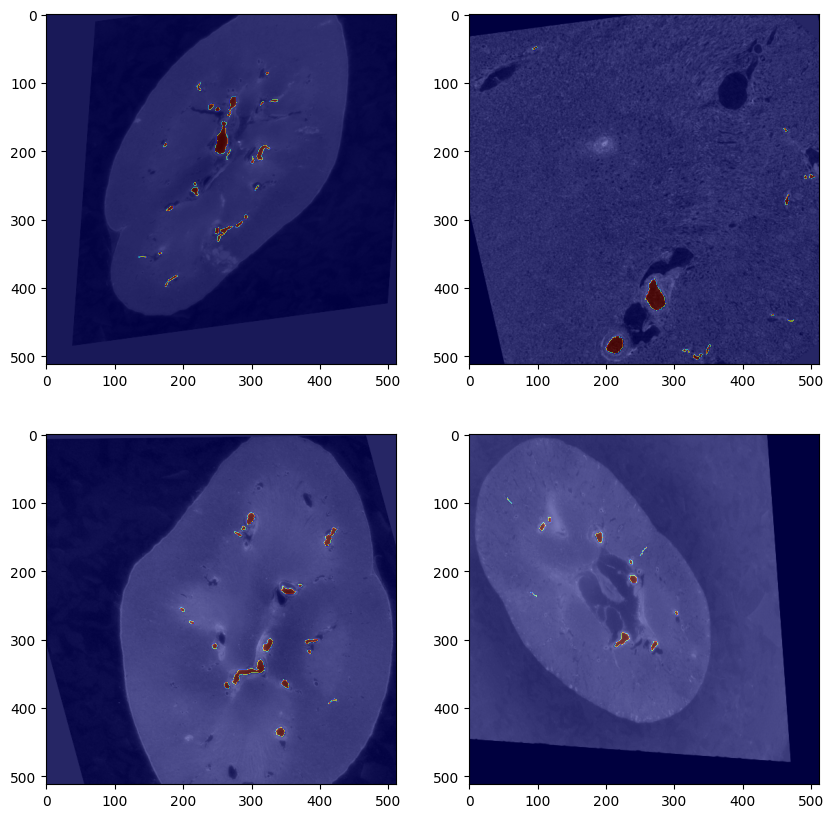

In [43]:

batch_size = 2
num_batches = 2

dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

fig, ax = plt.subplots(num_batches, batch_size, figsize=(5 * batch_size, 5*num_batches))

for i, batch in enumerate(dataloader):
    img = batch['img']
    mask = batch['mask']
    for b in range(img.shape[0]):
        img_b = img[b, 0, :, :].numpy()
        mask_b = mask[b, 0, :, :].numpy()
        ax[i][b].imshow(img_b, cmap='gray')
        ax[i][b].imshow(mask_b, cmap='jet', alpha=0.5)

    if i == num_batches - 1:
        break

plt.show()